In [18]:
import tensorflow as tf
import numpy as np

In [19]:
tf.__version__

'2.4.1'

In [20]:
input_seq = tf.zeros([64, 100, 4], tf.int32)
output_seq = tf.zeros([64, 100, 1], tf.int32)

# Transformer

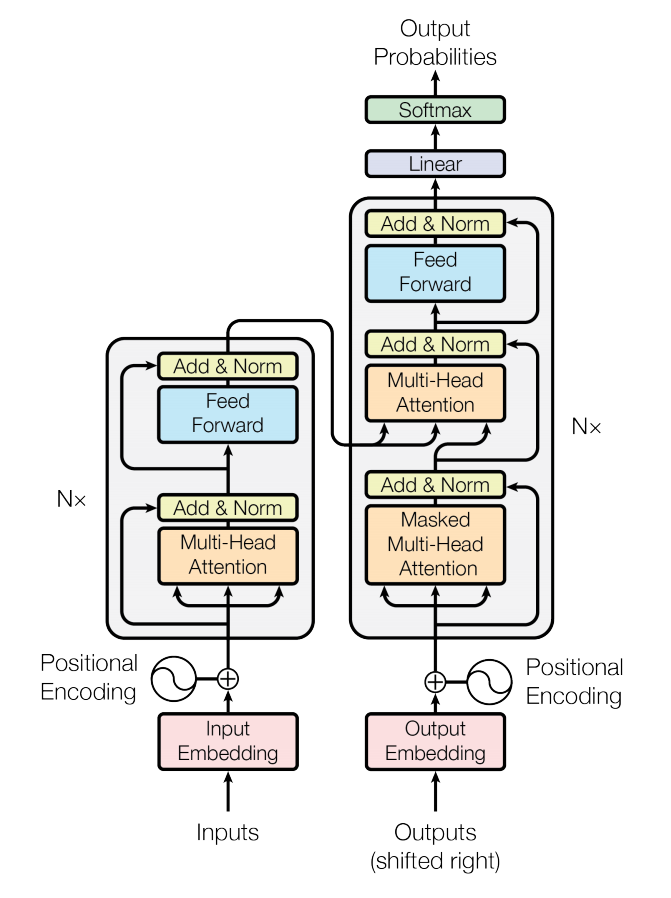

## Scaled Dot Product Attention 

In [21]:
class ScaledDotProductAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(**kwargs).__init__()
    
    def build(self, input_shape):    
        self.query_layer = tf.keras.layers.Dense(4)
        self.value_layer = tf.keras.layers.Dense(4)
        self.key_layer = tf.keras.layers.Dense(4)
        super().build(input_shape)
        
    def call(self, x):
        Q = self.query_layer(x)
        K = self.key_layer(x)
        V = self.value_layer(x)
        print('Q = ' + str(Q.shape))
        print('K = ' + str(K.shape))
        print('V = ' + str(V.shape))
        QK = tf.matmul(Q, K, transpose_b=True)
        QK = QK / tf.math.sqrt(4.)
        print('QK = ' + str(QK.shape))
        softmax_QK = tf.nn.softmax(QK, axis=-1)
        attention = tf.matmul(softmax_QK, V)
        print('attention = ' + str(attention.shape))
        return attention

def test():
    layer_input = tf.keras.Input(shape=(100, 4))
    attention = ScaledDotProductAttention()(layer_input)
    model = tf.keras.Model(layer_input, attention)
    model.summary()
    return model

m_test = test()
out = m_test(input_seq)
print(out.shape)

Q = (None, 100, 4)
K = (None, 100, 4)
V = (None, 100, 4)
QK = (None, 100, 100)
attention = (None, 100, 4)
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 100, 4)]          0         
_________________________________________________________________
scaled_dot_product_attention (None, 100, 4)            60        
Total params: 60
Trainable params: 60
Non-trainable params: 0
_________________________________________________________________
Q = (64, 100, 4)
K = (64, 100, 4)
V = (64, 100, 4)
QK = (64, 100, 100)
attention = (64, 100, 4)
(64, 100, 4)


## Positional Encoding

In [22]:
class PositionalEncodingSin(tf.keras.layers.Layer):
    
    def __init__(self, dim, seq_len = 100, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        if dim % 2 == 1: dim += 1 # max_dims must be even
        p, i = np.meshgrid(np.arange(seq_len), np.arange(dim // 2))
        pos_emb = np.empty((1, seq_len, dim))
        pos_emb[0, :, ::2] = np.sin(p / 10000**(2 * i / dim)).T
        pos_emb[0, :, 1::2] = np.cos(p / 10000**(2 * i / dim)).T
        self.positional_embedding = tf.constant(pos_emb.astype(self.dtype))
        
    def call(self, inputs):
        shape = tf.shape(inputs)
        return inputs + self.positional_embedding[:, :shape[-2], :shape[-1]]

In [23]:
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, dim, seq_len = 100, **kwargs):
        self.dim = dim
        self.seq_len = seq_len
        super(**kwargs).__init__()
  
    def build(self, input_shape):
        self.positional_encoding = tf.keras.layers.Embedding( self.seq_len, self.dim)
        super().build(input_shape)
  
    def call(self, x):
        embed = self.positional_encoding(x)
        return embed

## Look Ahead Mask

In [24]:
def create_look_ahead_mask(size):
    mask = tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

print(create_look_ahead_mask(10))

tf.Tensor(
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]], shape=(10, 10), dtype=float32)


## Multi Head Attention

In [26]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, dim = 4, nb_head = 2, **kwargs):
        self.dim = dim
        self.nb_head = nb_head
        self.head_dim = self.dim  // self.nb_head
        super(**kwargs).__init__()

    def build(self, input_shape):
        self.query_layer = tf.keras.layers.Dense(self.dim)
        self.value_layer = tf.keras.layers.Dense(self.dim)
        self.key_layer = tf.keras.layers.Dense(self.dim)
        self.out_proj = tf.keras.layers.Dense(self.dim)
        super().build(input_shape)
  

    def mask_softmax(self, x, mask):
        x_expe = tf.math.exp(x)
        x_expe_masked = x_expe * mask
        x_expe_sum = tf.reduce_sum(x_expe_masked, axis=-1)    
        x_expe_sum = tf.expand_dims(x_expe_sum, axis=-1)
        softmax = x_expe_masked / x_expe_sum
        return softmax


    def call(self, x, mask=None):

        in_query, in_key, in_value = x

        # [None, seq_len, dim]   [None, seq_len, dim]   [None, seq_len, dim]
        Q = self.query_layer(in_query)
        K = self.key_layer(in_key)
        V = self.value_layer(in_value)

        batch_size = tf.shape(Q)[0]
   

        Q = tf.reshape(Q, [batch_size, 100, self.nb_head, self.head_dim])
        K = tf.reshape(K, [batch_size, 100, self.nb_head, self.head_dim])
        V = tf.reshape(V, [batch_size, 100, self.nb_head, self.head_dim])


        Q = tf.transpose(Q, [0, 2, 1, 3]) # [batch_size, nb_head, seq_len, head_dim]
        K = tf.transpose(K, [0, 2, 1, 3])
        V = tf.transpose(V, [0, 2, 1, 3])


        Q = tf.reshape(Q, [batch_size * self.nb_head, 100, self.head_dim])  # [batch_size * nb_head, seq_len, head_dim]
        K = tf.reshape(K, [batch_size * self.nb_head, 100, self.head_dim])
        V = tf.reshape(V, [batch_size * self.nb_head, 100, self.head_dim])


        # Scaled dot product attention
        QK = tf.matmul(Q, K, transpose_b=True) # [batch_size * nb_head, seq_len, seq_len]
        QK = QK / tf.math.sqrt(tf.cast(self.dim, dtype = tf.float32))


        # [1, 0, 0, 0, 0, 0] # [seq_len, seq_len]
        # [1, 1, 0, 0, 0, 0] 
        # [1, 1, 1, 0, 0, 0] 
        # [1, 1, 1, 1, 0, 0] 
        # [1, 1, 1, 1, 0, 0] 

        if mask is not None:
            QK = QK * mask

            softmax_QK = self.mask_softmax(QK, mask)  # [batch_size * nb_head, seq_len, seq_len]
        else:
            softmax_QK = tf.nn.softmax(QK, axis=-1)   # [batch_size * nb_head, seq_len, seq_len]
        
        attention = tf.matmul(softmax_QK, V)   # [batch_size * nb_head, seq_len, head_dim]

        attention = tf.reshape(
            attention, [batch_size, self.nb_head, 100, self.head_dim])
        
        attention = tf.transpose(attention, [0, 2, 1, 3]) # [batch_size, seq_len, nb_head, head_dim]

        # Concat
        attention = tf.reshape(
            attention, [batch_size, 100, self.nb_head*self.head_dim]  # [batch_size, seq_len, dim]
        )

        out_attention = self.out_proj(attention)  # [batch_size, seq_len, dim]

        return out_attention

In [27]:
def test_mha():
    layer_input = tf.keras.Input(shape=(100, 4))

    multi_attention = MultiHeadAttention()((layer_input,layer_input,layer_input))

    model = tf.keras.Model(layer_input, multi_attention)
    model.summary()
    return model

m_test = test_mha()
out = m_test(input_seq)
print(out.shape)

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 100, 4)]     0                                            
__________________________________________________________________________________________________
multi_head_attention_2 (MultiHe (None, 100, 4)       80          input_12[0][0]                   
                                                                 input_12[0][0]                   
                                                                 input_12[0][0]                   
Total params: 80
Trainable params: 80
Non-trainable params: 0
__________________________________________________________________________________________________
(64, 100, 4)


## Encoder Part

In [28]:
class EncoderLayer(tf.keras.layers.Layer):

    def __init__(self, **kwargs):
        super(**kwargs).__init__()
  
    def build(self, input_shape):
        self.multi_head_attention = MultiHeadAttention()
        self.norm = tf.keras.layers.LayerNormalization()
        self.dense_out = tf.keras.layers.Dense(self.multi_head_attention.dim)
        super().build(input_shape)
  
    def call(self, x):
        attention = self.multi_head_attention((x, x, x)) # Multi Head Attention
        post_attention = self.norm(attention + x) # ADD & NORM

        x = self.dense_out(post_attention) # FEED FORWARD
        enc_output = self.norm(x + post_attention) # ADD & NORM

        return enc_output

In [29]:
#The Encoder layer is only a repetition of EncoderLayer layers

class Encoder(tf.keras.layers.Layer):

    def __init__(self, nb_encoder, **kwargs):
        self.nb_encoder = nb_encoder
        super(**kwargs).__init__()
  
    def build(self, input_shape):

        self.encoder_layers = []
        for nb in range(self.nb_encoder):
            self.encoder_layers.append(EncoderLayer())
        super().build(input_shape)

    def call(self, x):
        for encoder_layer in self.encoder_layers:
            x = encoder_layer(x)
        return x


def test():
    layer_input = tf.keras.Input(shape=(100, 4))
    enc_output = Encoder(nb_encoder=6)(layer_input)
    model = tf.keras.Model(layer_input, enc_output)
    model.summary()
    return model

m_test = test()
out = m_test(input_seq)
print(out.shape)

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 100, 4)]          0         
_________________________________________________________________
encoder_4 (Encoder)          (None, 100, 4)            648       
Total params: 648
Trainable params: 648
Non-trainable params: 0
_________________________________________________________________
(64, 100, 4)


## Decoder Part

In [30]:
class DecoderLayer(tf.keras.layers.Layer):

    def __init__(self, **kwargs):
        super(**kwargs).__init__()
  
    def build(self, input_shape):
        self.multi_head_self_attention = MultiHeadAttention()
        self.multi_head_enc_attention = MultiHeadAttention()
        self.norm = tf.keras.layers.LayerNormalization()

        self.proj_output = tf.keras.layers.Dense(self.multi_head_enc_attention.dim)

        super().build(input_shape)
  
    def call(self, x):

        enc_output, dec_input, mask = x

        self_attention = self.multi_head_self_attention(  # Masked decoder Multi Head Attention  # ends with 1
            (dec_input, dec_input, dec_input), mask=mask
        )
        post_self_att = self.norm(dec_input + self_attention)  # ADD & NORM

        
        enc_attention = self.multi_head_enc_attention(
            (post_self_att, enc_output, enc_output)   # Query of decoder, Value/Keys of Encoder
        )
        post_enc_attention = self.norm(enc_attention + post_self_att) # ADD & NORM
        
        proj_out = self.proj_output(post_enc_attention) # FEED FORWARD
        dec_output = self.norm(proj_out + post_enc_attention) # ADD & NORM

        return dec_output
  

In [31]:
#The Decoder layer is only a repetition of DecoderLayer layers

class Decoder(tf.keras.layers.Layer):

    def __init__(self, nb_decoder, **kwargs):
        self.nb_decoder = nb_decoder
        super(**kwargs).__init__()
  
    def build(self, input_shape):

        self.decoder_layers = []
        for nb in range(self.nb_decoder):
            self.decoder_layers.append(DecoderLayer())

        super().build(input_shape)
  
    def call(self, x):

        enc_output, dec_input, mask = x

        for decoder_layer in self.decoder_layers:
            dec_input = decoder_layer((enc_output, dec_input, mask))
            
        return dec_input


## Final Model

In [32]:
def create_transformer_model():
    input_seq = tf.keras.Input(shape=(100, 4))
    output_seq = tf.keras.Input(shape=(100, 1))

    # Positional encodings
    enc_positional_encoding = PositionalEncoding(4)(tf.range(100))
    dec_positional_encoding = PositionalEncoding(1)(tf.range(100))

    # Add the positional encoding
    input_embedding = input_seq + enc_positional_encoding
    output_embedding = output_seq + dec_positional_encoding

    # Encoder
    enc_output = Encoder(nb_encoder=6)(input_embedding)

    # mask + Decoder
    mask = create_look_ahead_mask(100)
    dec_output = Decoder(nb_decoder=6)((enc_output, output_embedding, mask))

    # Predictions
    out_pred = tf.keras.layers.Dense(1)(dec_output)
    predictions = tf.nn.sigmoid(out_pred)

    model = tf.keras.Model([input_seq, output_seq], predictions)
    model.summary()
    return model

transformer = create_transformer_model()
out = transformer((input_seq, output_seq))
print(out.shape)


Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 100, 4)]     0                                            
__________________________________________________________________________________________________
tf.__operators__.add (TFOpLambd (None, 100, 4)       0           input_14[0][0]                   
__________________________________________________________________________________________________
input_15 (InputLayer)           [(None, 100, 1)]     0                                            
__________________________________________________________________________________________________
encoder_5 (Encoder)             (None, 100, 4)       648         tf.__operators__.add[0][0]       
____________________________________________________________________________________________